In [987]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

from imblearn.over_sampling import SMOTE

In [988]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [989]:
file = tf.keras.utils
df1 = pd.read_csv('../data/2020/20_agg_data.csv')
df2 = pd.read_csv('../data/2019/19_agg_data.csv')
df3 = pd.read_csv('../data/2018/18_agg_data.csv')
df4 = pd.read_csv('../data/2021/21_agg_data.csv')
df_list = [df1, df2, df3]

In [990]:
comb_df = pd.concat(df_list)
comb_df.describe()

,Time,Max Concentration,Last Pit,Air Temp,Track Temp,Wind Speed,Yellow
count,11873.000000,11873.000000,11873.000000,11873.000000,11873.000000,11873.000000,11873.000000
mean,40628.467952,6.720277,184.903608,60.742147,61.618211,2.145229,0.009770
std,24135.242623,3.043953,269.281758,7.813136,9.732104,2.085498,0.098364
min,20.000000,0.533049,0.333333,46.400000,32.000000,0.000000,0.000000
25%,19820.000000,4.567957,46.683700,54.899960,55.000040,0.600000,0.000000
50%,40080.000000,6.048387,54.456783,60.400040,62.000060,1.300000,0.000000
75%,59900.000000,8.333333,122.065217,66.599960,64.999940,3.200000,0.000000
max,86440.000000,33.333333,1074.120850,77.000000,98.000060,15.100000,1.000000


In [991]:
neg, pos = np.bincount(comb_df['Yellow'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 11873
    Positive: 116 (0.98% of total)



In [992]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = 10 #(1 / neg)*(total)/2.0 
weight_for_1 = 13 #(1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 10.00
Weight for class 1: 13.00


In [993]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None, dropout=0.5, input_shape=(3,)):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          128, activation='relu',
          input_shape=input_shape),
      keras.layers.Dropout(dropout),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=.001),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [994]:
EPOCHS = 100
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [995]:
initial_bias = np.log([pos/neg])

In [996]:
model = make_model(output_bias=initial_bias)

In [997]:
initial_weights = '../data/inital_weights'
model.save_weights(initial_weights)

In [998]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [999]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.4,.8])
        else:
            plt.ylim([-0.1,1])

        plt.legend()

In [1000]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Green Flags Predicted (True Negatives): ', cm[0][0])
    print('Yellow Flags Incorrectly Predicted (False Positives): ', cm[0][1])
    print('Yellow Flags Missed (False Negatives): ', cm[1][0])
    print('Yellow Flags Correctly Predicted (True Positives): ', cm[1][1])
    print('Total Yellow Flags: ', np.sum(cm[1]))

In [1001]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

Testing on df 4
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
loss :  2.800546169281006
tp :  39.0
fp :  3655.0
tn :  610.0
fn :  9.0
accuracy :  0.15047530829906464
precision :  0.010557660833001137
recall :  0.8125
auc :  0.4296209216117859



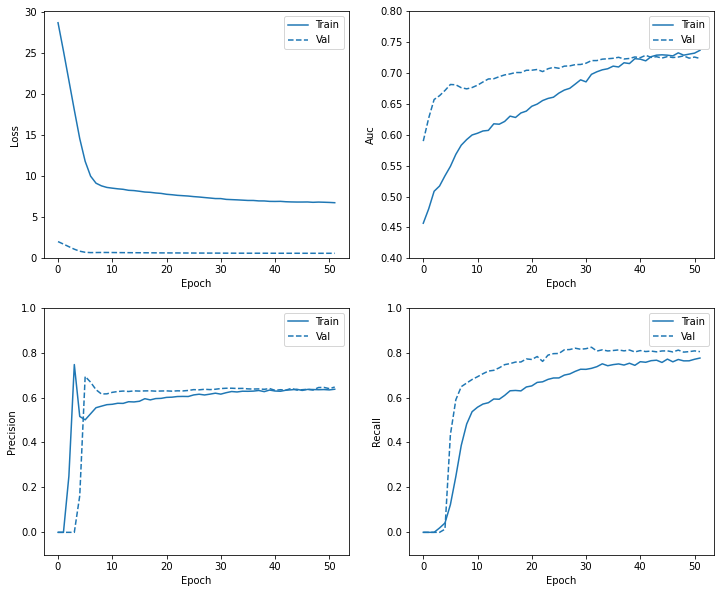

Green Flags Predicted (True Negatives):  610
Yellow Flags Incorrectly Predicted (False Positives):  3655
Yellow Flags Missed (False Negatives):  9
Yellow Flags Correctly Predicted (True Positives):  39
Total Yellow Flags:  48


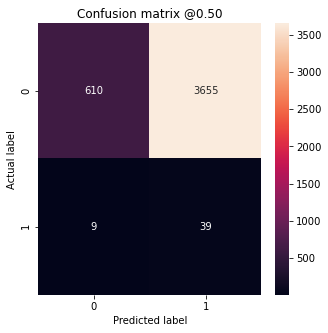

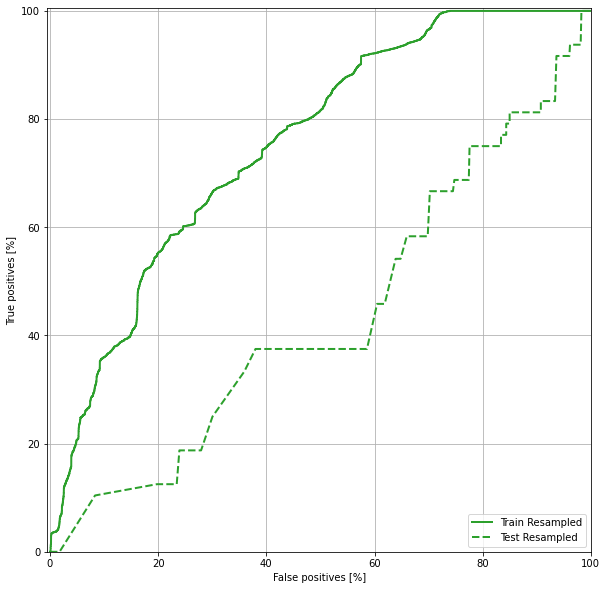

In [1002]:
# for i in range(0, 4):
i=3
df1 = pd.read_csv('../data/2020/20_agg_data.csv')
df2 = pd.read_csv('../data/2019/19_agg_data.csv')
df3 = pd.read_csv('../data/2018/18_agg_data.csv')
df4 = pd.read_csv('../data/2021/21_agg_data.csv')
df_list = [df1, df2, df3, df4]

print('Testing on df', str(i+1))
test_df = df_list[i]
test_df.pop('Time')
if(i != 3):
    test_df.pop('Max Concentration')
test_df.pop('Air Temp')

train_list = df_list[:i] + df_list[i+1:]
train_df = pd.concat(train_list) 
train_df.pop('Time')
train_df.pop('Max Concentration')
train_df.pop('Air Temp')

eps = 0.001 
train_df['Last Pit'] = np.log(train_df['Last Pit']+eps)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Yellow'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Yellow'))
test_labels = np.array(test_df.pop('Yellow'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


# Standard Scale and clip
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

# SMOTE transformd
oversample = SMOTE()
train_features, train_labels = oversample.fit_resample(train_features, train_labels)
val_features, val_labels = oversample.fit_resample(val_features, val_labels)

# Run model
SMOTE_model = make_model(dropout=0.18, input_shape=(train_features.shape[-1],))
SMOTE_model.load_weights(initial_weights)


SMOTE_history = SMOTE_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    verbose=0,
    class_weight=class_weight
)

# plots
plot_metrics(SMOTE_history)
train_predictions_SMOTE = SMOTE_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_SMOTE = SMOTE_model.predict(test_features, batch_size=BATCH_SIZE)

SMOTE_results = SMOTE_model.evaluate(test_features, test_labels,
                                         batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(SMOTE_model.metrics_names, SMOTE_results):
    print(name, ': ', value)
print()
plt.show()

plot_cm(test_labels, test_predictions_SMOTE)
plt.show()

plot_roc("Train Resampled", train_labels, train_predictions_SMOTE, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_SMOTE, color=colors[2], linestyle='--')
plt.legend(loc='lower right')
plt.show()